<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/DBD_ChargeSpeed1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

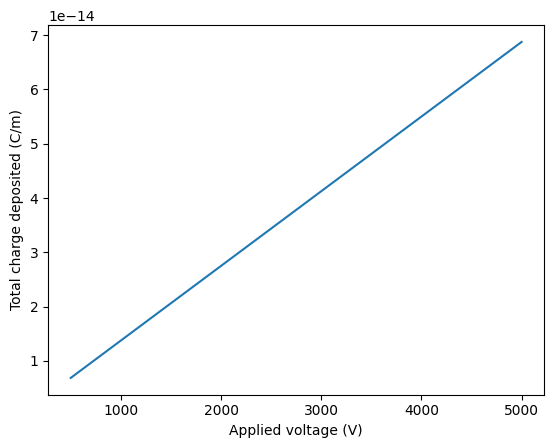

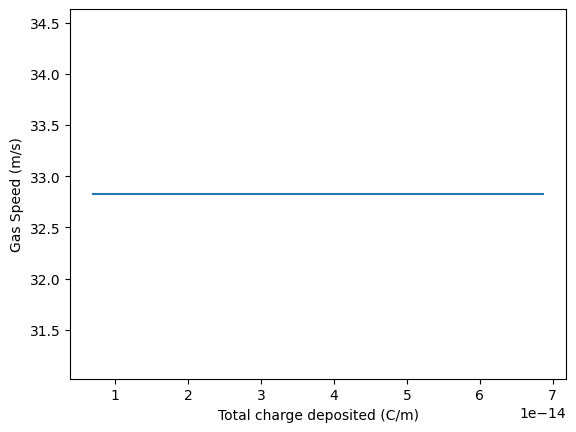

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Simulation parameters
f = 10000  # Frequency (Hz)
E_rms = np.linspace(500, 5000, 10) / (np.sqrt(2) * np.pi * 0.1)  # Root mean square electric field (V/m)
L = 1  # Length of discharge (m)
d = 0.1  # Distance between electrodes (m)
W = 0.1  # Width of electrodes (m)
A = L * W  # Surface area of electrodes (m^2)
mu_0 = 4 * np.pi * 10**(-7)  # Permeability of free space (H/m)
epsilon_0 = 8.854 * 10**(-12)  # Permittivity of free space (F/m)
epsilon_r = 4  # Relative permittivity of dielectric material
sigma = 10**(-5)  # Conductivity of dielectric material (S/m)
ec = 1.6e-19 #

Q_total = []
v_gas = []

for E in E_rms:
    V = np.sqrt(2) * np.pi * 0.1 * E * L
    
    def electric_field(x, t):
        if 0 <= x <= d:
            return E * np.sin(2 * np.pi * f * t + 2 * np.pi * x / d)
        elif d < x <= L:
            return E * np.sin(2 * np.pi * f * t + 2 * np.pi * (L - x) / d)
        else:
            return 0

    def charge_density(x, t):
        return sigma * electric_field(x, t) / (2 * epsilon_0 * epsilon_r)

    def dbd_ode(y, x, t):
        V, Q = y
        dVdx = -charge_density(x, t) / epsilon_0
        dQdx = sigma * A * electric_field(x, t)

        # Kinetic reactions due to electron impact
        alpha = 0.01  # Ionization rate coefficient (m^3/s)
        beta = 1e-4  # Recombination rate coefficient (m^3/s)
        ne = Q / (epsilon_0 * A * L)  # Electron density (m^-3)
        ni = ne / 100  # Ion density assuming ionization level of 1%
        n = ne + ni  # Total plasma density
        # Balance equations for electrons and ions
        dne_dt = alpha * ne * ni - beta * ne**2
        dni_dt = alpha * ne * ni - beta * ni**2
        dQdx += ec * (dne_dt + dni_dt) * A * L

        return [dVdx, dQdx]

    y0 = [0, 0]
    x = np.linspace(0, L, 1000)
    t = np.linspace(0, 1 / f, 1000)

    sol = odeint(dbd_ode, y0, x, args=(t[0],))

    V = sol[:, 0]
    Q = sol[:, 1]

    # Calculate charge accumulation on dielectric surface
    Q_surf = ec*np.sqrt(2 * epsilon_r * epsilon_0 * np.abs(V) * E * W)

    # Add charge to total
    Q_total.append(np.trapz(Q_surf, x))

    # Calculate gas speed
   
# Calculate gas speed
v_gas = []
for Q in Q_total:
   ne = Q / (epsilon_0 * A * L) # Electron density (m^-3)
   ni = ne / 100 # Ion density assuming ionization level of 1%
   n = ne + ni # Total plasma density
   v = (Q / (ec * A)) * (mu_0 / (2 * np.pi)) * np.log((2 * L) / d) / n
   v_gas.append(v)

# Plot total charge deposited versus applied voltage
plt.plot(E_rms * np.sqrt(2) * np.pi * 0.1, Q_total)
plt.xlabel('Applied voltage (V)')
plt.ylabel('Total charge deposited (C/m)')
plt.show()

# Plot gas speed versus total charge
plt.plot(Q_total, v_gas)
plt.ylabel('Gas Speed (m/s)')
plt.xlabel('Total charge deposited (C/m)')
plt.show()